In [2]:
import os
import numpy as np
from numpy import array, ma, genfromtxt
import pandas as pd

In [3]:
# The CANlab/WAVi Pain Study is Pre-Formatted to resemble BIDS neuroimaging formatting
# If your study does not abide to the following structure, please revisit previous scripts
# .../StudyRepo
# -------------> /raw
# -------------------> /*.art
# -------------------> /*.eeg
# -------------------> /*.evt
# -------------> /task1
# -------------------> /group1
# ------------------------> /sub1_ftype1.csv
# ------------------------> /sub1_ftype2.csv
# ------------------------> /...
# ------------------------> /subn_ftypen.csv
# -------------------> /...
# -------------------> /groupn
# -------------> /...
# -------------> /taskn

In [4]:
# Before running this script, you should already have 
# converted your raw data into CSV formats as shown above

In [5]:
try:
    os.chdir("CANlabStudy")
    directory=os.getcwd()
except:
    print("I couldn't find the study directory.\n")
    print("Please enter the full path of the study repository:")
    directory = input()

while(not os.path.exists(directory)):
    print("\n")
    print("The directory you supplied could not be found.")
    print("Please enter the full path of the study directory containing EEG, ART, EVT files:")
    directory = input()
    
os.chdir(directory)

In [6]:
# print("Which task would you like to load? \n p300? \n flanker? \n chronic? \n rest?")
# task = ""
# while(task == ""):
#     task = input() 
# os.chdir(task)

In [7]:
def go_to_task(task):
    if(os.getcwd() != (directory+"/"+task)):
        os.chdir(directory+"/"+task)

class taskInfo():
    def __init__(self):
        self.pain_fnames = os.listdir("1")
        self.ctrl_fnames = os.listdir("2")
        self.pain_subs = []
        self.ctrl_subs = []
        for fname in self.pain_fnames:
            if(fname[:3] not in self.pain_subs):
                self.pain_subs.append(fname[:3])
        for fname in self.ctrl_fnames:
            if(fname[:3] not in self.ctrl_subs):
                self.ctrl_subs.append(fname[:3])
    
def load_csv(sub):
    eeg = genfromtxt(sub+"_eeg.csv", delimiter=",")
    art = genfromtxt(sub+"_art.csv", delimiter=",")
    return(eeg, art)

def apply_art_mask_nan(data, artifact):
    mx = ma.masked_array(data, mask=artifact)
    mx = ma.filled(mx.astype(float), np.nan)
    return(mx)

def apply_art_mask_zero(data, artifact):
    mx = ma.masked_array(data, mask=artifact)
    mx = ma.filled(mx.astype(float), 0)
    return(mx)

#provide length as num of cycles, 250 Hz freq
def find_contigs(min_length):
    return(null)
    
def load_p300():
    go_to_task("p300")
    p300_pain = []
    p300_ctrl = []
    info = taskInfo()
    os.chdir("1")
    for sub in info.pain_subs:
        eeg, art = load_csv(sub)
        p300_pain.append(apply_art_mask_zero(eeg, art))
    os.chdir("..")
    os.chdir("2")
    for sub in info.ctrl_subs:
        eeg, art = load_csv(sub)
        p300_ctrl.append(apply_art_mask_zero(eeg, art))
    os.chdir("..")
    return(p300_pain, p300_ctrl)

def load_flanker():
    go_to_task("flanker")
    flanker_pain = []
    flanker_ctrl = []
    info = taskInfo()
    os.chdir("1")
    for sub in info.pain_subs:
        eeg, art = load_csv(sub)
        flanker_pain.append(apply_art_mask_zero(eeg, art))
    os.chdir("..")
    os.chdir("2")
    for sub in info.ctrl_subs:
        eeg, art = load_csv(sub)
        flanker_ctrl.append(apply_art_mask_zero(eeg, art))
    os.chdir("..")
    return(flanker_pain, flanker_ctrl)
    
def load_chronic():
    go_to_task("chronic")
    chronic_pain = []
    chronic_ctrl = []
    info = taskInfo()
    os.chdir("1")
    for sub in info.pain_subs:
        eeg, art = load_csv(sub)
        chronic_pain.append(apply_art_mask_zero(eeg, art))
    os.chdir("..")
    os.chdir("2")
    for sub in info.ctrl_subs:
        eeg, art = load_csv(sub)
        chronic_ctrl.append(apply_art_mask_zero(eeg, art))
    os.chdir("..")
    return(chronic_pain, chronic_ctrl)
    
def load_rest():
    go_to_task("rest")
    rest_pain = []
    rest_ctrl = []
    info = taskInfo()
    os.chdir("1")
    for sub in info.pain_subs:
        eeg, art = load_csv(sub)
        rest_pain.append(apply_art_mask_zero(eeg, art))
    os.chdir("..")
    os.chdir("2")
    for sub in info.ctrl_subs:
        eeg, art = load_csv(sub)
        rest_ctrl.append(apply_art_mask_zero(eeg, art))
    os.chdir("..")
    return(rest_pain, rest_ctrl)
    
p300_pain, p300_control = load_p300()
chronic_pain, chronic_control = load_chronic()

In [8]:
print("Number of patients: " + str(len(p300_pain)))
print("Number of controls: " + str(len(p300_control)))
print("Total N: " + str(len(p300_pain)+len(p300_control)))
print(" \nThat's not a lot! Let's get more by arranging the data into contigs of some desired length.")

Number of patients: 11
Number of controls: 8
Total N: 19
 
That's not a lot! Let's get more by arranging the data into contigs of some desired length.


In [9]:
def sec_to_cyc(seconds):
    return(seconds * 250)
        
def generate_sparse_contigs(run, length):
    i = 0
    contigs = []
    startindexes = []
    while i < run.shape[0]-length:
        stk = run[i:(i+length),:]
        if not np.any(np.isnan(stk)):
            contigs.append(stk)
            startindexes.append(i)
            i+=length
        else:
            i+=1
    return contigs, startindexes

def generate_all_contigs(run, length):
    i = 0
    contigs = []
    startindexes = []
    while i < run.shape[0]-length:
        stk = run[i:(i+length),:]
        contigs.append(stk)
        startindexes.append(i)
        i+=length
    return contigs, startindexes

In [10]:
def get_contigs_from_trials(trials):
    all_contigs = []
    print("How many seconds long should each contig be?")
    cycles = sec_to_cyc(int(input()))
    for run in trials:
        all_contigs.append(generate_sparse_contigs(run, cycles))
    return(all_contigs)

In [58]:
p300_pain_contigs = get_contigs_from_trials(p300_pain)
p300_ctrl_contigs = get_contigs_from_trials(p300_control)

chronic_pain_contigs = get_contigs_from_trials(chronic_pain)
chronic_ctrl_contigs = get_contigs_from_trials(chronic_control) 

How many seconds long should each contig be?
3
How many seconds long should each contig be?
3
How many seconds long should each contig be?
3
How many seconds long should each contig be?
3


In [120]:
def amps_by_subject(contigs):
    amps_by_subject=[]
    for sub in contigs:
        amps = [np.sum(np.square(contig)) for contig in sub[0]]
        amps_by_subject.append(amps)
    return(amps_by_subject)

def amps_by_group(contigs):
    amps_by_group=[]
    for sub in contigs:
        for contig in sub[0]:
            amp = np.sum(np.square(contig))
            amps_by_group.append(amp)
    return(amps_by_group)

In [121]:
print((p300_pain_contigs[0][0][1]))

[[  0.   1.   0. ...   3.   1. -25.]
 [ -3.  -1.   0. ...   0.   0. -24.]
 [ -3.  -1.   0. ...  -2.  -1. -24.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [146]:
p300_pain_amps = amps_by_group(p300_pain_contigs)
p300_ctrl_amps = amps_by_group(p300_ctrl_contigs)

chronic_pain_amps = amps_by_group(chronic_pain_contigs)
chronic_ctrl_amps = amps_by_group(chronic_ctrl_contigs)

(0.0, 160.0)

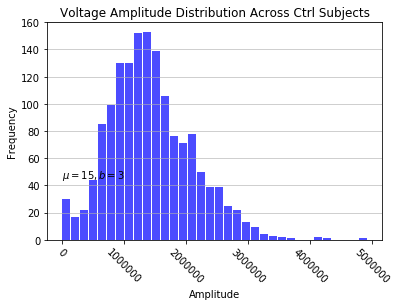

In [148]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=chronic_ctrl_amps, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Amplitude')
plt.xticks(rotation=315)
plt.ylabel('Frequency')
plt.title('Voltage Amplitude Distribution Across Ctrl Subjects')
plt.text(23,45,r'$\mu=15, b=3$')
maxfreq = n.max()

plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 90.0)

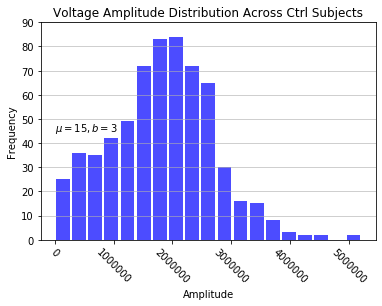

In [145]:
n, bins, patches = plt.hist(x=p300_ctrl_amps, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Amplitude')
plt.xticks(rotation=315)
plt.ylabel('Frequency')
plt.title('Voltage Amplitude Distribution Across Ctrl Subjects')
plt.text(23,45,r'$\mu=15, b=3$')
maxfreq = n.max()

plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [134]:
p300_pain_std = np.std(p300_pain_amps)
p300_ctrl_std = np.std(p300_ctrl_amps)

print(p300_pain_std)
print(p300_ctrl_std)

791937.9158265755
883612.7928977264


In [13]:
# def load_per_task(task):
#     switcher = {
#         p300: load_p300,
#         flanker: load_flanker,
#         chronic: load_chronic,
#         rest: load_rest
#     }
#     func = switcher.get(argument, lambda: "Invalid task")

In [13]:
os.chdir(directory+"/contigs")

In [14]:
def contigs_to_csv(group):
    where = input("Where should I write these contigs?")
    prefix = input("What should I prefix the files with?")
    i = 0
    for sub in group:      
        if (len(sub[0])>0):
            for contig in sub[0]:
                np.savetxt(where+"/"+prefix+"_"+str(i)+".csv", contig, delimiter=",", fmt="%2.0f")
                i+=1
                
def contigs_to_csv_split(group, task, prefix):
    if("train" not in os.listdir()):
        os.mkdir("train")
        os.mkdir("test")
    if(task not in os.listdir("train")):
        os.chdir("train")
        os.mkdir(task)
        os.chdir("../test")
        os.mkdir(task)
        os.chdir("..")
    i = 0
    for sub in group:
        if(len(sub[0])>0):
            for contig in sub[0]:
                if(i%3==0):
                    np.savetxt(directory+"/contigs/test/"+task+"/"+prefix+"_"+str(i)+".csv", contig, delimiter=",", fmt="%2.0f")
                else:
                    np.savetxt(directory+"/contigs/train/"+task+"/"+prefix+"_"+str(i)+".csv", contig, delimiter=",", fmt="%2.0f")
                i+=1

In [16]:
contigs_to_csv_split(p300_pain_contigs, "p300", "pain")
contigs_to_csv_split(p300_ctrl_contigs, "p300", "ctrl")
contigs_to_csv_split(chronic_pain_contigs, "chronic", "pain")
contigs_to_csv_split(chronic_ctrl_contigs, "chronic", "ctrl")